# Group 1 - Data Mining Project: Recommendation Systems
## Evaluating: Singular Value Decomposition (SVD), Bayesian Personalized Ranking (BPR), and Transformer based Recommendation (Bert4Rec)



### System level installations

Upgrade our pip environment to ensure we have access to the latest pip packages on pypi.

In [1]:
!python3 -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Install python dependencies

In [2]:
# Pip deps for SVD and BPR
!python3 -m pip install \
datasets \
implicit \
matplotlib \
pillow \
scikit-surprise \
tqdm

# Pip deps for Bert4Rec
!python3 -m pip install \
recbole \
kmeans-pytorch \
ray

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.6 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357284 sha256=29fc0852dbe1dc0e018a1a422deef21ca79bf8f4836d7e5d4710e3d8f6c7b5d9
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━

Clone the repo into the workspace

In [6]:
!git clone https://github.com/joelpolizzi/DSC210-group_proj.git

Cloning into 'DSC210-group_proj'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 272 (delta 75), reused 115 (delta 43), pack-reused 92 (from 1)
Receiving objects: 100% (272/272), 27.96 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (117/117), done.


### Project imports

In [3]:
# Imports for SVD and BPR
import gzip
import math
import os
import random
import requests
import time
from tempfile import TemporaryDirectory
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import scipy
from io import BytesIO
from PIL import Image
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset as DS
from implicit import bpr
from implicit.evaluation import train_test_split as bpr_train_test_split
from implicit.evaluation import leave_k_out_split, precision_at_k, AUC_at_k, ndcg_at_k, ranking_metrics_at_k
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import Tuple

# Imports for Bert4Rec
from recbole.quick_start import run_recbole


### Data Loading: Load the Amazon reviews dataset from Huggingface

In [4]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Musical_Instruments", trust_remote_code=True)
print(dataset["full"][0])
dataset_items = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Musical_Instruments", trust_remote_code=True)
print(dataset_items["full"][0])

#Print our splits
print(dataset.keys())
print(len(dataset["full"]))
print(dataset_items.keys())
print(len(dataset_items["full"]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Musical_Instruments.jsonl:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

{'rating': 5.0, 'title': 'Five Stars', 'text': 'Great headphones, comfortable and sound is good. No complaints. I would buy again.', 'images': [], 'asin': 'B003LPTAYI', 'parent_asin': 'B003LPTAYI', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650586000, 'helpful_vote': 0, 'verified_purchase': True}


meta_Musical_Instruments.jsonl:   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/213593 [00:00<?, ? examples/s]

{'main_category': 'Musical Instruments', 'title': 'Pearl Export Lacquer EXL725S/C249 5-Piece New Fusion Drum Set with Hardware, Honey Amber', 'average_rating': 4.2, 'rating_number': 22, 'features': ['Item may ship in more than one box and may arrive separately', '(22x18, 10x7, 12x8, 16x16, 14x5.5)', 'P930 Demonator Pedal', '830 Hardware Pack', 'Matching snare, REMO snare batter side head'], 'description': ["Introducing the best selling drum set of all time... Export Series returns and this time with a lacquer finish. EXL Export Lacquer Series incorporates Pearl's S.S.T. Superior Shell Technology, Opti-Loc tom mounts, all-new 830 Series Hardware with a P-930 Pedal, and a choice of three amazing stocking finishes."], 'price': 'None', 'images': {'hi_res': ['https://m.media-amazon.com/images/I/91RuLqvx9IL._AC_SL1500_.jpg', 'https://m.media-amazon.com/images/I/81q8vubRs-L._AC_SL1500_.jpg', None, 'https://m.media-amazon.com/images/I/81ubSuvhnrL._AC_SL1500_.jpg', 'https://m.media-amazon.com/i

### Load the dataset into a pandas dataframe

In [10]:
# Dataframe for training
random_state = 33
df = pd.DataFrame(dataset['full'][:len(dataset['full']) // 10]).sample(frac=0.5, random_state=random_state)
print(df.head())
print(df.dtypes)

        rating                   title  \
36861      5.0              Five Stars   
36728      4.0          My first baton   
142396     5.0             Works Great   
83052      3.0  Good sound with issues   
218173     5.0     Quality made cable.   

                                                     text images        asin  \
36861                           Favorite headphones ever!     []  B003LPTAYI   
36728   Nicely made, pleasant balance. I haven't seen ...     []  B000EEJIV4   
142396  Works fine with older Casio WK-1200.  More erg...     []  B019SKINGA   
83052   I had pops, modulation and a white noise issue...     []  B01AUSB4ZQ   
218173                                       Works great.     []  B07RGP5WYL   

       parent_asin                       user_id      timestamp  helpful_vote  \
36861   B003LPTAYI  AHEW4RN4A7C5DZKQ3V3C5WIIDHJQ  1489184381000             0   
36728   B000EEJIV4  AG43EYXSK76E5O6KIOH7EYC2KASA  1366828748000             0   
142396  B019SKINGA  AE2

In [13]:
# Initialize the reader object with a rating scale between 1 and 5
reader = Reader(rating_scale=(1, 5))

# Load the dataframe content observing title, text, and rating
surprise_data = Dataset.load_from_df(df[['user_id', 'parent_asin', 'rating']], reader)

In [14]:
# Create an items dataframe
df_items = pd.DataFrame(dataset_items['full'])

In [15]:
# userIDs is a map from user_id to index
# itemIDS is a map from item_id to index
# indexToUser is a map from the index to the user ID
# indexToItem is a map from the index to the item ID
# asinToParentAsin is a map from asin to parent asin (item ID of all variants)
userIDs, itemIDs, indexToUser, indexToItem, parentIDs, indexToParent, asinToParentAsin = {}, {}, {}, {}, {}, {}, {}

for idx, row in tqdm(df.iterrows()):
    user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]
    if user_id not in userIDs:
        userIDs[user_id] = len(userIDs)
        indexToUser[userIDs[user_id]] = user_id
    if item_id not in itemIDs:
        itemIDs[item_id] = len(itemIDs)
        indexToItem[itemIDs[item_id]] = item_id
        asinToParentAsin[item_id] = parent_item_id
    if parent_item_id not in parentIDs:
        parentIDs[parent_item_id] = len(parentIDs)
        indexToParent[parentIDs[parent_item_id]] = parent_item_id


nUsers, nItems, nParents = len(userIDs), len(itemIDs), len(parentIDs)
print(f"There are a total of {nUsers} users and {nParents} products with a total of {nItems} items including all variants.")

150872it [00:08, 16951.37it/s]

There are a total of 80440 users and 47852 products with a total of 56798 items including all variants.


# SVD Based Recommendation

In [16]:
# Number of latent factors
k = 5

# Initialize the Single Value Decomposition model for collaborative filtering
svd = SVD(n_factors = k, verbose = True)

#Split the data into training and test sets. Only use 25% of the data for speed.
trainset, testset = train_test_split(surprise_data, test_size=.25, random_state=random_state)

# Fit the model to the training set
svd.fit(trainset)

# Assign predictions to the test set of the trained model
predictions = svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [17]:
# root mean squared error
accuracy.rmse(predictions, verbose=True)

# A sample Prediction contains the user id (uid), item id(iid), actual rating (r_ui), estimated rating (est), and additional details (details).
(predictions[0])

RMSE: 1.1280


Prediction(uid='AHFFCP63UNK2HZOQJFJHVWAONKFQ', iid='B0B8M5FJ9W', r_ui=5.0, est=4.588578621837441, details={'was_impossible': False})

In [18]:
def get_top_n(predictions, n=3):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=3)

In [19]:
# Print the recommended items for the first user
uid0, iids = None, None
for uid, user_ratings in top_n.items():
    uid0 = uid
    iids = [iid for (iid, _) in user_ratings]
print(f"User id that we inspect: {uid0}")

User id that we inspect: AHQDYKP77D5ZFKU5TYD3TZWFLNTA


In [20]:
# Check the similarity between a user and their items latent factors

user_ids = trainset.all_users()  # This returns a list of all user ids
inner_user_id = random.choice(user_ids)
user_vector = svd.pu[inner_user_id]
raw_user_id = trainset.to_raw_uid(inner_user_id)

# Get the list of items (item_ids) from the trainset
item_ids = trainset.all_items()

preds = []
# Predict ratings for a specific user for all items
for item_id in item_ids:
    raw_item_id = trainset.to_raw_iid(item_id)
    preds.append(svd.predict(raw_user_id, raw_item_id))

# Extract the item IDs that have the highest predicted ratings
predicted_items = sorted(preds, key=lambda x: x.est, reverse=True)
# print(predicted_items[:5])

# Get the item IDs sorted by the predicted rating
for pred in predicted_items[:3]:
    inner_item_id = trainset.to_inner_iid(pred.iid)
    item_vector = svd.qi[inner_item_id]
    print(np.dot(user_vector, item_vector))

0.002040838208804945
0.029080246221323387
0.009024529901305308


In [21]:
# Check what the user has reviewed
user0_reviews = DS.from_pandas(df).filter(lambda row: row["user_id"] == uid0)

Filter:   0%|          | 0/150872 [00:00<?, ? examples/s]

In [22]:
user0_reviewed_items = user0_reviews["parent_asin"]
user0_reviewd_items_images = dataset_items.filter(lambda row: row["parent_asin"] in user0_reviewed_items)

Filter:   0%|          | 0/213593 [00:00<?, ? examples/s]

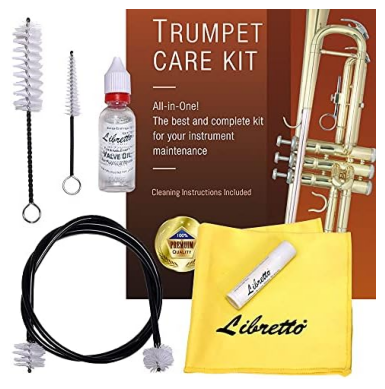

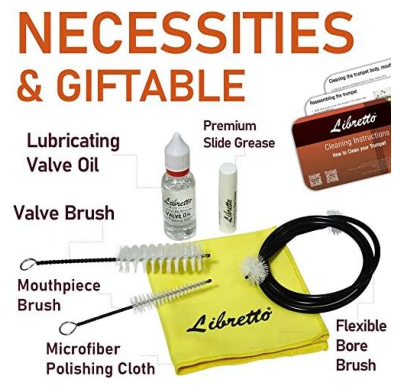

In [23]:
def show_images(dataset):
    image_urls = []
    # URL of the image
    for img in dataset["full"]["images"]:
        for large_image in img["large"][:2]: # show 2 images of each item that is recommended
            image_urls.append(large_image)

    for url in image_urls:
        # Fetch and display the image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Display the image inline
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

show_images(user0_reviewd_items_images)

In [24]:
# Check what the model recommends for the user
uid0_images = []
filtered_dataset = dataset_items.filter(lambda row: row["parent_asin"] in iids)

filtered_dataset["full"].to_pandas().head()

Filter:   0%|          | 0/213593 [00:00<?, ? examples/s]

main_category                                              title  \
0  Sports & Outdoors  Libretto Trumpet (Cornet) ALL-INCLUSIVE Care K...   

   average_rating  rating_number  \
0             4.7           2455   

                                            features description  price  \
0  [All-Inclusive Kit - Everything you need for i...          []  17.95   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos     store  \
0  {'title': ['Trumpet care kit', 'Libretto Trump...  Libretto   

                                          categories  \
0  [Musical Instruments, Instrument Accessories, ...   

                                             details parent_asin  \
0  {"Item Package Dimensions L x W x H": "5.98 x ...  B07DR9Z128   

  bought_together subtitle author  
0            None     None   None

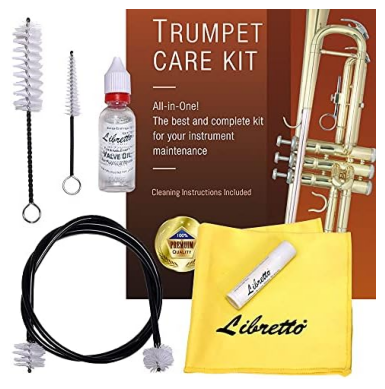

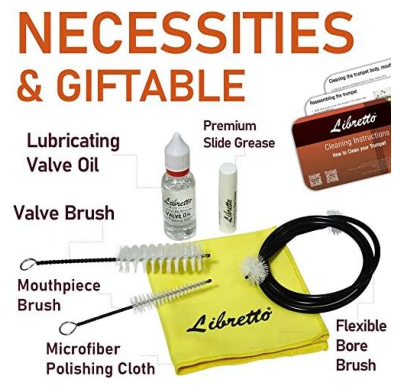

In [25]:
show_images(filtered_dataset)

### Recommendations for items and accessories that match with user's previous choices. Also, we have approximated the huge matrix with latent factors of much lower dimension!


In [26]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [27]:
precisions, recalls = precision_recall_at_k(predictions, k=3, threshold=4)

# Take the average over all values
precision = np.mean(np.array([prec for prec in precisions.values()]))
recall = np.mean(np.array([rec for rec in recalls.values()]))


print(f"Precision={precision}, recall={recall}")

Precision=0.782208918841411, recall=0.7825631878159769


# Bayesian Personalized Ranking

### Preparation

In [28]:
# Create a new BPR dataframe
df_bpr = pd.DataFrame(dataset['full'][:len(dataset['full']) // 10]).sample(frac=.5, random_state=random_state)

random_state = 33

In [29]:
user_id_counts, parent_id_counts = defaultdict(int), defaultdict(int)
for idx, row in tqdm(df.iterrows()):
    user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]
    user_id_counts[user_id] += 1
    parent_id_counts[parent_item_id] += 1

150872it [00:08, 16867.38it/s]


Iterate over users and parents (This cell takes ~10 minutes to execute)

In [30]:
df = df_bpr
threshold_users_list = [10, 20, 30, 35, 40]
threshold_parents_list = [25, 50, 75, 100, 125, 150]

bpr_precisions = []
bpr_aucs = []
bpr_ndcgs = []
threshold_pairs = []
models = []

for threshold_users in threshold_users_list:
    for threshold_parents in threshold_parents_list:
        # userIDs is a map from user_id to index
        # itemIDS is a map from item_id to index
        # indexToUser is a map from the index to the user ID
        # indexToItem is a map from the index to the item ID
        # asinToParentAsin is a map from asin to parent asin (item ID of all variants)
        # Assign our variables with empty dictionaries
        userIDs, itemIDs, indexToUser, indexToItem, parentIDs, indexToParent, asinToParentAsin = {}, {}, {}, {}, {}, {}, {}

        # Iterate over the dataframe rows
        for idx, row in tqdm(df.iterrows()):
            # Assign our variables to associations in our dataset
            user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]

            # Check if user_id is already in the dictionary, if not then assign it with a unique index
            if user_id not in userIDs and user_id_counts[user_id] >= threshold_users:
                userIDs[user_id] = len(userIDs)
                indexToUser[userIDs[user_id]] = user_id

            # Check item_ids inside the dictionary
            if item_id not in itemIDs:
                # Assign unique index to the item_id
                itemIDs[item_id] = len(itemIDs)
                # Map the index to the item
                indexToItem[itemIDs[item_id]] = item_id
                # Associate the item_id to the parent item id
                asinToParentAsin[item_id] = parent_item_id

            # Add the parent to the set of unique parentIDs
            if parent_item_id not in parentIDs and parent_id_counts[parent_item_id] >= threshold_parents:
                parentIDs[parent_item_id] = len(parentIDs)
                indexToParent[parentIDs[parent_item_id]] = parent_item_id


        # Get the lengths to print the totals
        nUsers, nItems, nParents = len(userIDs), len(itemIDs), len(parentIDs)
        print(f"For threshold_users = {threshold_users}, threshold_items = {threshold_parents}, there are a total of {nUsers} users and {nParents} products with a total of {nItems} items including all variants.")

        # Initialized after extracting the number of users and items
        Xui = scipy.sparse.lil_matrix((nUsers, nParents))

        # Iterate over each row in the dataframe
        for ifx, row in tqdm(df.iterrows()):
            user_id, item_id = row["user_id"], row["parent_asin"]
            if user_id_counts[user_id] >= threshold_users and parent_id_counts[item_id] >= threshold_parents:
              #Only storing positive feedback instances
              Xui[userIDs[user_id],parentIDs[item_id]] = 1

        # Convert matrix to a compressed sparse row
        Xui_csr = scipy.sparse.csr_matrix(Xui)

#         print(Xui_csr)
        print(f"Sparsity of the matrix = {(1 - (Xui_csr.nnz/(Xui_csr.shape[0]*Xui_csr.shape[1]))):.6f}%")

        Xui_train, Xui_test = leave_k_out_split(Xui_csr, K=1, random_state=random_state)

        # Hyperparameter of latent factors
        k = 5
        # Initialze the BPR model with the hyperparameters
        model = bpr.BayesianPersonalizedRanking(factors = k, random_state=random_state, iterations=100, regularization=0.01)
        # Fit the BPR model to the training set
        model.fit(Xui_train)
        bpr_precision = precision_at_k(model, Xui_train, Xui_test, 10, True)
        bpr_auc = AUC_at_k(model, Xui_train, Xui_test, 10, True)
        bpr_ndcg = ndcg_at_k(model, Xui_train, Xui_test, 10, True)
        threshold_pairs.append((threshold_users, threshold_parents))
        models.append(model)
    #     print(f"Precision={bpr_precision}, AUC={bpr_auc}, NDCG={bpr_ndcg}")
        bpr_precisions.append(bpr_precision)
        bpr_aucs.append(bpr_auc)
        bpr_ndcgs.append(bpr_ndcg)


150872it [00:09, 15796.05it/s]


For threshold_users = 10, threshold_items = 25, there are a total of 1487 users and 645 products with a total of 56798 items including all variants.


150872it [00:08, 17668.57it/s]

Sparsity of the matrix = 0.995089%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

150872it [00:09, 15736.34it/s]


For threshold_users = 10, threshold_items = 50, there are a total of 1487 users and 232 products with a total of 56798 items including all variants.


150872it [00:07, 20474.34it/s]

Sparsity of the matrix = 0.991942%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

150872it [00:09, 15268.38it/s]


For threshold_users = 10, threshold_items = 75, there are a total of 1487 users and 123 products with a total of 56798 items including all variants.


150872it [00:08, 17190.62it/s]

Sparsity of the matrix = 0.988568%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

150872it [00:09, 16044.68it/s]


For threshold_users = 10, threshold_items = 100, there are a total of 1487 users and 71 products with a total of 56798 items including all variants.


150872it [00:07, 19175.90it/s]

Sparsity of the matrix = 0.985281%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

150872it [00:10, 14662.69it/s]


For threshold_users = 10, threshold_items = 125, there are a total of 1487 users and 50 products with a total of 56798 items including all variants.


150872it [00:08, 17446.92it/s]

Sparsity of the matrix = 0.983268%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

150872it [00:09, 15383.25it/s]


For threshold_users = 10, threshold_items = 150, there are a total of 1487 users and 35 products with a total of 56798 items including all variants.


150872it [00:08, 17586.89it/s]

Sparsity of the matrix = 0.979979%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

150872it [00:09, 15173.54it/s]


For threshold_users = 20, threshold_items = 25, there are a total of 318 users and 645 products with a total of 56798 items including all variants.


150872it [00:07, 20191.27it/s]

Sparsity of the matrix = 0.992248%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

150872it [00:10, 14993.82it/s]


For threshold_users = 20, threshold_items = 50, there are a total of 318 users and 232 products with a total of 56798 items including all variants.


150872it [00:08, 17440.07it/s]

Sparsity of the matrix = 0.987503%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

150872it [00:10, 14795.59it/s]


For threshold_users = 20, threshold_items = 75, there are a total of 318 users and 123 products with a total of 56798 items including all variants.


150872it [00:07, 18950.69it/s]

Sparsity of the matrix = 0.981771%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

150872it [00:10, 14571.81it/s]


For threshold_users = 20, threshold_items = 100, there are a total of 318 users and 71 products with a total of 56798 items including all variants.


150872it [00:08, 17253.35it/s]

Sparsity of the matrix = 0.976924%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

150872it [00:09, 16643.82it/s]


For threshold_users = 20, threshold_items = 125, there are a total of 318 users and 50 products with a total of 56798 items including all variants.


150872it [00:08, 18160.12it/s]

Sparsity of the matrix = 0.974528%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

150872it [00:10, 14731.38it/s]


For threshold_users = 20, threshold_items = 150, there are a total of 318 users and 35 products with a total of 56798 items including all variants.


150872it [00:08, 18401.38it/s]

Sparsity of the matrix = 0.969901%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

150872it [00:09, 15681.82it/s]


For threshold_users = 30, threshold_items = 25, there are a total of 115 users and 645 products with a total of 56798 items including all variants.


150872it [00:08, 17379.54it/s]

Sparsity of the matrix = 0.990239%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

150872it [00:10, 14560.62it/s]


For threshold_users = 30, threshold_items = 50, there are a total of 115 users and 232 products with a total of 56798 items including all variants.


150872it [00:07, 20167.65it/s]

Sparsity of the matrix = 0.984820%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

150872it [00:10, 14540.88it/s]


For threshold_users = 30, threshold_items = 75, there are a total of 115 users and 123 products with a total of 56798 items including all variants.


150872it [00:08, 17332.48it/s]

Sparsity of the matrix = 0.978296%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

150872it [00:09, 15796.92it/s]


For threshold_users = 30, threshold_items = 100, there are a total of 115 users and 71 products with a total of 56798 items including all variants.


150872it [00:08, 18627.74it/s]


Sparsity of the matrix = 0.973301%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

150872it [00:10, 14573.36it/s]


For threshold_users = 30, threshold_items = 125, there are a total of 115 users and 50 products with a total of 56798 items including all variants.


150872it [00:10, 14293.00it/s]

Sparsity of the matrix = 0.972000%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

150872it [00:15, 9537.61it/s] 


For threshold_users = 30, threshold_items = 150, there are a total of 115 users and 35 products with a total of 56798 items including all variants.


150872it [00:08, 16808.10it/s]


Sparsity of the matrix = 0.965714%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

150872it [00:09, 15564.34it/s]


For threshold_users = 35, threshold_items = 25, there are a total of 80 users and 645 products with a total of 56798 items including all variants.


150872it [00:09, 16291.48it/s]

Sparsity of the matrix = 0.989787%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

150872it [00:13, 11021.29it/s]


For threshold_users = 35, threshold_items = 50, there are a total of 80 users and 232 products with a total of 56798 items including all variants.


150872it [00:08, 17206.46it/s]

Sparsity of the matrix = 0.984698%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

150872it [00:09, 15272.70it/s]


For threshold_users = 35, threshold_items = 75, there are a total of 80 users and 123 products with a total of 56798 items including all variants.


150872it [00:07, 18866.45it/s]

Sparsity of the matrix = 0.978963%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

150872it [00:10, 14515.63it/s]


For threshold_users = 35, threshold_items = 100, there are a total of 80 users and 71 products with a total of 56798 items including all variants.


150872it [00:08, 18681.97it/s]

Sparsity of the matrix = 0.974648%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

150872it [00:10, 14778.23it/s]


For threshold_users = 35, threshold_items = 125, there are a total of 80 users and 50 products with a total of 56798 items including all variants.


150872it [00:08, 17591.18it/s]

Sparsity of the matrix = 0.973000%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

150872it [00:10, 14553.75it/s]


For threshold_users = 35, threshold_items = 150, there are a total of 80 users and 35 products with a total of 56798 items including all variants.


150872it [00:07, 20476.62it/s]

Sparsity of the matrix = 0.966786%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

150872it [00:11, 13342.08it/s]


For threshold_users = 40, threshold_items = 25, there are a total of 55 users and 645 products with a total of 56798 items including all variants.


150872it [00:08, 17776.63it/s]

Sparsity of the matrix = 0.988894%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

150872it [00:09, 15426.21it/s]


For threshold_users = 40, threshold_items = 50, there are a total of 55 users and 232 products with a total of 56798 items including all variants.


150872it [00:07, 18962.97it/s]

Sparsity of the matrix = 0.983699%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

150872it [00:11, 13656.01it/s]


For threshold_users = 40, threshold_items = 75, there are a total of 55 users and 123 products with a total of 56798 items including all variants.


150872it [00:08, 17504.57it/s]

Sparsity of the matrix = 0.978271%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

150872it [00:09, 15951.81it/s]


For threshold_users = 40, threshold_items = 100, there are a total of 55 users and 71 products with a total of 56798 items including all variants.


150872it [00:08, 17854.86it/s]

Sparsity of the matrix = 0.974136%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

150872it [00:10, 13817.76it/s]


For threshold_users = 40, threshold_items = 125, there are a total of 55 users and 50 products with a total of 56798 items including all variants.


150872it [00:08, 18288.99it/s]

Sparsity of the matrix = 0.973091%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

150872it [00:09, 15959.31it/s]


For threshold_users = 40, threshold_items = 150, there are a total of 55 users and 35 products with a total of 56798 items including all variants.


150872it [00:09, 16682.63it/s]

Sparsity of the matrix = 0.965195%


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [33]:
# Assign max variables
max_precision_index = bpr_precisions.index(max(bpr_precisions))
max_auc_index = bpr_aucs.index(max(bpr_aucs))
max_ndcg_index = bpr_ndcgs.index(max(bpr_ndcgs))



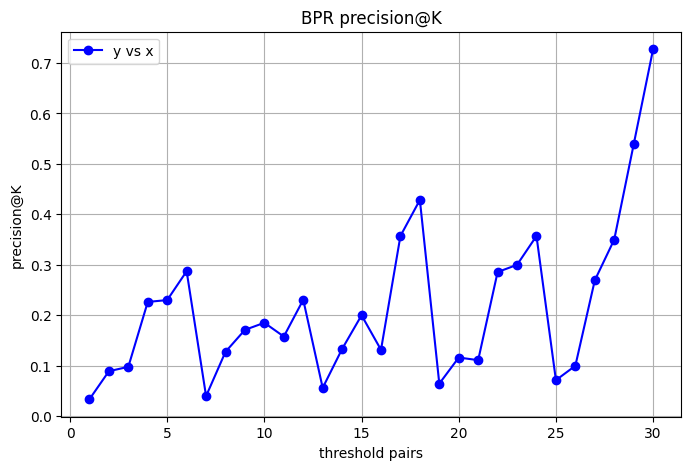

The max precision@K = 0.7272727272727273 for threshold_users = 40 and threshold_parents = 150


In [34]:
# Plot our precision
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, len(threshold_users_list)*len(threshold_parents_list) + 1)), bpr_precisions, marker='o', linestyle='-', color='b', label='y vs x')
plt.xlabel('threshold pairs')
plt.ylabel('precision@K')
plt.title('BPR precision@K')
plt.legend()
plt.grid(True)
plt.show()
print(f"The max precision@K = {bpr_precisions[max_precision_index]} for threshold_users = {threshold_pairs[max_precision_index][0]} and threshold_parents = {threshold_pairs[max_precision_index][1]}")

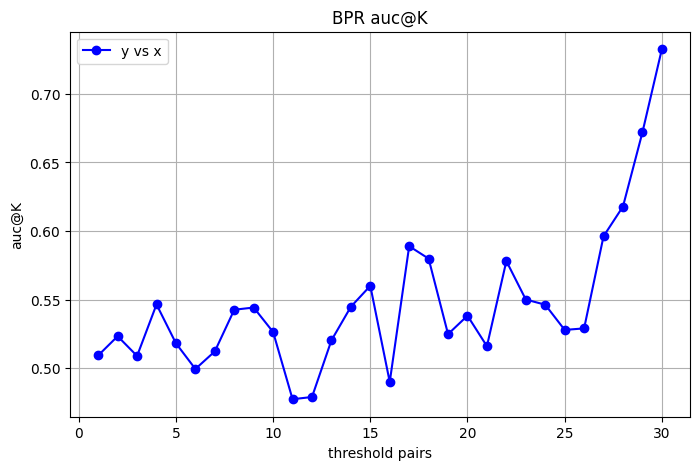

The max auc@K = 0.7326203208556149 for threshold_users = 40 and threshold_parents = 150


In [35]:
# Plot AUC
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, len(threshold_users_list)*len(threshold_parents_list) + 1)), bpr_aucs, marker='o', linestyle='-', color='b', label='y vs x')
plt.xlabel('threshold pairs')
plt.ylabel('auc@K')
plt.title('BPR auc@K')
plt.legend()
plt.grid(True)
plt.show()
print(f"The max auc@K = {bpr_aucs[max_auc_index]} for threshold_users = {threshold_pairs[max_auc_index][0]} and threshold_parents = {threshold_pairs[max_auc_index][1]}")

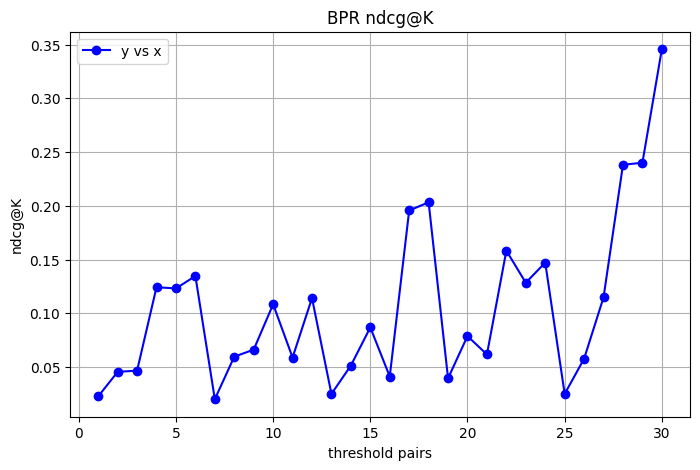

The max ndcg@K = 0.34568762111527157 for threshold_users = 40 and threshold_parents = 150


In [36]:
# Plot the normalized discount cumulative gain
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, len(threshold_users_list)*len(threshold_parents_list) + 1)), bpr_ndcgs, marker='o', linestyle='-', color='b', label='y vs x')
plt.xlabel('threshold pairs')
plt.ylabel('ndcg@K')
plt.title('BPR ndcg@K')
plt.legend()
plt.grid(True)
plt.show()
print(f"The max ndcg@K = {bpr_ndcgs[max_ndcg_index]} for threshold_users = {threshold_pairs[max_ndcg_index][0]} and threshold_parents = {threshold_pairs[max_ndcg_index][1]}")

### Although the matrix remains highly sparse, we see that there is improved reliability of the recommendations when we deal with frequent users and popular items. The trend of popular items is also observed among all 3 metrics, such that for every user threshold, we tend to see better scores for the more popular items (associated with more reviews). This aligns with our intuition that recommended items will tend to also be popular among users.

In [37]:
model = models[max_auc_index] # let us use the best AUC model

itemFactors = model.item_factors
userFactors = model.user_factors

uid0index = 2
recommended = model.recommend(uid0index, Xui_test[uid0index]) # Top k Recommendations for the user
print(recommended)

(array([ 7, 33,  4,  5, 26, 22, 32, 11, 19, 10], dtype=int32), array([0.17271094, 0.11886995, 0.09715575, 0.08237144, 0.07183759,
       0.03733428, 0.01479949, 0.01447044, 0.00577151, 0.        ],
      dtype=float32))


In [38]:
print(f"Inspecting items for user {uid0}")

Inspecting items for user AHQDYKP77D5ZFKU5TYD3TZWFLNTA


In [39]:
# Create an empty list for the recommended items
recommended_items = []

# Loop over each recommended ID
for recommendedId in recommended[0]:

    # Search for rows where the parent asin matches
    row = df_items[df_items["parent_asin"] == indexToParent[recommendedId]]

    # Append the rows to the recommended items list
    recommended_items.append(row)

# Concatonate the dataframes into a single frame
x = pd.concat(recommended_items, ignore_index=True)
print(len(x))

# Show the concatonated dataframe
x

10


main_category                                              title  \
0  Musical Instruments  D'Addario Guitar Strings - XL Nickel Electric ...   
1  Musical Instruments               Jim Dunlop Pick Holder, Black, 3/Bag   
2  Musical Instruments  D'Addario Guitar Strings - Phosphor Bronze Aco...   
3  Musical Instruments  GLS Audio Instrument Cable - Amp Cord for Bass...   
4  Musical Instruments  Snark SN-5 Tuner for Guitar, Bass and Violin (...   
5  Musical Instruments  Ohm Store Tibetan Singing Bowl Set — Meditatio...   
6  Musical Instruments        Snark SN-8 Super Tight All Instrument Tuner   
7  Musical Instruments  D'Addario Accessories Guitar Tuner - Micro Hea...   
8  Musical Instruments  Snark SN5X Clip-On Tuner for Guitar, Bass & Vi...   
9            Computers     Microsoft Surface Touch Cover Keyboard | Black   

   average_rating  rating_number  \
0             4.8          37890   
1             4.7          10085   
2             4.7          60133   
3             4.8          25245   
4             4.6           6778   
5             4.6          24368   
6             4.6           5514   
7             4.5          15961   
8             4.6          34682   
9             4.3            829   

                                            features  \
0  [BESTSELLING SET – XL Nickel are our best-sell...   
1  [Spring-loaded, sleek pick holder keeps picks ...   
2  [CORROSION-RESISTANT, PRECISION WOUND – D’Adda...   
3  [Durable: Built to last, our electric guitar c...   
4  [Full Color Display, Display rotates 360 degre...   
5  [AUTHENTIC HAND HAMMERED TIBETAN SINGING BOWL ...   
6  [Super Tight Tuning, Faster, Brighter EZ Read ...   
7  [THE STEALTH TUNER - Your audience will never ...   
8  [Full Color Display, Features frequency range ...   
9  [Lightweight, 3mm thin pressure-sensitive keyb...   

                                         description   price  \
0  [XL Nickel Wound electric guitar strings are t...    5.99   
1  [Keep your picks where you need them. This spr...    9.81   
2  [D'Addario was the first to use Phosphor Bronz...   10.99   
3                                                 []    14.3   
4                    [Guitar, Bass and Violin Tuner]    None   
5                                                 []   28.97   
6  [The Newest! “Tunes Tighter So You Sound Bette...   16.99   
7    [D'Addario Ns Micro Universal Tuner (PW-CT-13)]   18.99   
8  [Snark SN5X Clip-On Tuner for Guitar, Bass & V...   14.97   
9  [3.25mm thin Weighs less than 0.46 lbs Pressur...  129.98   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   
1  {'hi_res': ['https://m.media-amazon.com/images...   
2  {'hi_res': ['https://m.media-amazon.com/images...   
3  {'hi_res': ['https://m.media-amazon.com/images...   
4  {'hi_res': ['https://m.media-amazon.com/images...   
5  {'hi_res': ['https://m.media-amazon.com/images...   
6  {'hi_res': ['https://m.media-amazon.com/images...   
7  {'hi_res': ['https://m.media-amazon.com/images...   
8  {'hi_res': ['https://m.media-amazon.com/images...   
9  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos                  store  \
0  {'title': ['D'Addario EXL120 Nickel Wound Elec...              D'Addario   
1  {'title': ['It’s HUUUGE', 'Dunlop 5005 Pick Ho...             JIM DUNLOP   
2  {'title': ['D'Addario Phosphor Bronze Acoustic...              D'Addario   
3  {'title': ['How the audio cable has held up to...              GLS Audio   
4  {'title': ['Very good', 'It almost works perfe...                  SNARK   
5  {'title': ['Beautiful singing bowl', 'Great', ...                    Ohm   
6  {'title': ['Honest Review Of Snark Tuner For G...                  SNARK   
7  {'title': ['D'Addario Accessories NS Micro Cli...  D'Addario Accessories   
8  {'title': ['Do not recommend.', 'Snark Sn5X cl...                  SNARK   
9  {'title': ['Honest Review of Mic

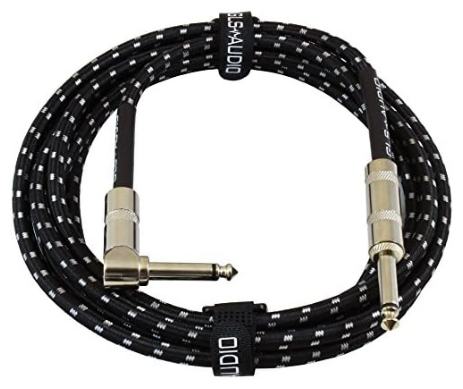

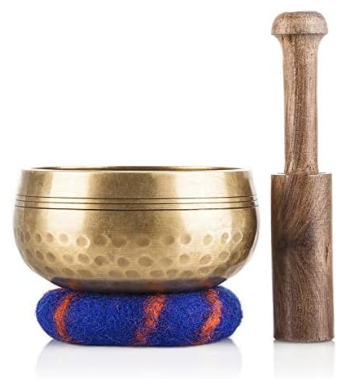

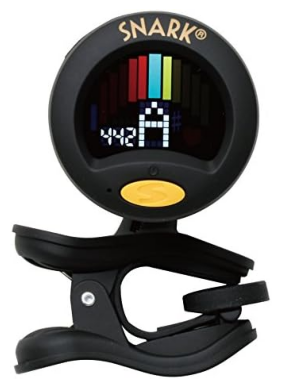

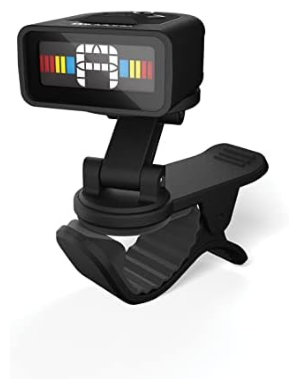

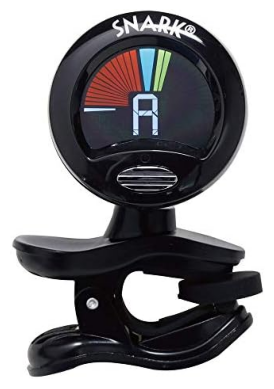

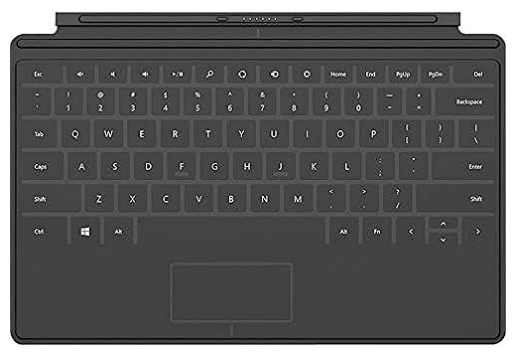

In [40]:
# show the images of the recommended items
def show_images(dataset):
    image_urls = []
    # URL of the image
    for img in dataset["images"]:
        for large_image in img["large"][:1]: # show 2 images of each item that is recommended
            image_urls.append(large_image)

    for url in image_urls:
        # Fetch and display the image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Display the image inline
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

show_images(x)

In [41]:
indexOfRelatedItem = 4
related = model.similar_items(indexOfRelatedItem) # Top 10 Highly similar to the 5th item (using cosine similarity)
print(related) # shows the index of the similar item and the similarity score (sorted from best to least)

(array([ 4,  6, 18,  7, 23, 26, 19, 32, 12, 10], dtype=int32), array([1.        , 0.49229202, 0.43566254, 0.30598366, 0.28144565,
       0.2756979 , 0.13042176, 0.04832483, 0.        , 0.        ],
      dtype=float32))


            main_category                                              title  \
3252  Musical Instruments  D'Addario Guitar Strings - Phosphor Bronze Aco...   

      average_rating  rating_number  \
3252             4.7          60133   

                                               features  \
3252  [CORROSION-RESISTANT, PRECISION WOUND – D’Adda...   

                                            description  price  \
3252  [D'Addario was the first to use Phosphor Bronz...  10.99   

                                                 images  \
3252  {'hi_res': ['https://m.media-amazon.com/images...   

                                                 videos      store  \
3252  {'title': ['D'Addario Phosphor Bronze Acoustic...  D'Addario   

                                             categories  \
3252  [Musical Instruments, Instrument Accessories, ...   

                                                details parent_asin  \
3252  {"Item Weight": "1.4 ounces", "Product Dimensi...  B

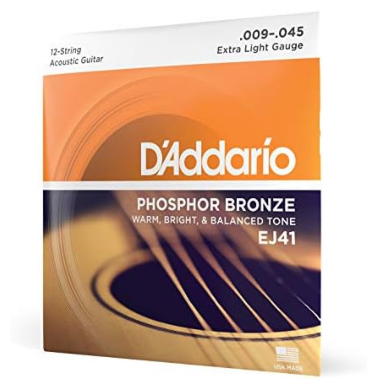

In [42]:
# What is the 5th item?
x = df_items[df_items["parent_asin"] == indexToParent[indexOfRelatedItem]]
print(x)
show_images(x)

In [43]:
# Create an empty list for the related items
related_items = []

# Loop over the related ID's
for relatedId in related[0]:
    # Find the parent ASIN coresponding to the related item ID
    parent_asin = indexToParent[relatedId]

    # Find rows where the parent asin matches
    row = df_items[df_items["parent_asin"] == parent_asin]

    # Append the row items to the related items list
    related_items.append(row)

# Concatonate the dataframes into a single dataframe
x = pd.concat(related_items, ignore_index=True)
print(len(x))

# Print the concatonated dataframe
x

10


main_category                                              title  \
0  Musical Instruments  D'Addario Guitar Strings - Phosphor Bronze Aco...   
1  Musical Instruments  On Stage XCG4 Velveteen Padded Tubular Guitar ...   
2  Musical Instruments  Ernie Ball Mondo Slinky Nickelwound Electric G...   
3  Musical Instruments  D'Addario Guitar Strings - XL Nickel Electric ...   
4  Musical Instruments  GoDpsMusic Music Stand (CC-MSTAND) (Carry bag ...   
5  Musical Instruments  Snark SN-5 Tuner for Guitar, Bass and Violin (...   
6  Musical Instruments  Snark SN5X Clip-On Tuner for Guitar, Bass & Vi...   
7  Musical Instruments        Snark SN-8 Super Tight All Instrument Tuner   
8  Musical Instruments  LEDwholesalers 12-Volt 16.4-ft RGB Color-Chang...   
9            Computers     Microsoft Surface Touch Cover Keyboard | Black   

   average_rating  rating_number  \
0             4.7          60133   
1             4.7          18219   
2             4.8         100615   
3             4.8          37890   
4             4.3          11064   
5             4.6           6778   
6             4.6          34682   
7             4.6           5514   
8             4.5           1763   
9             4.3            829   

                                            features  \
0  [CORROSION-RESISTANT, PRECISION WOUND – D’Adda...   
1  [Flush end caps to protect your instrument, Se...   
2  [Ernie Ball Slinkys are played by legends arou...   
3  [BESTSELLING SET – XL Nickel are our best-sell...   
4  [11.5" X 20" Bookplate Tilts And Is Fully Adju...   
5  [Full Color Display, Display rotates 360 degre...   
6  [Full Color Display, Features frequency range ...   
7  [Super Tight Tuning, Faster, Brighter EZ Read ...   
8  [Complete kit includes: flexible LED strip, co...   
9  [Lightweight, 3mm thin pressure-sensitive keyb...   

                                         description   price  \
0  [D'Addario was the first to use Phosphor Bronz...   10.99   
1  [Our best seller combines our special formula ...   38.95   
2  [Product Description, Ernie Ball Mondo Slinkys...    6.99   
3  [XL Nickel Wound electric guitar strings are t...    5.99   
4  [This Music Stand Folds Fast For Easy Storage ...   12.48   
5                    [Guitar, Bass and Violin Tuner]    None   
6  [Snark SN5X Clip-On Tuner for Guitar, Bass & V...   14.97   
7  [The Newest! “Tunes Tighter So You Sound Bette...   16.99   
8  [These LED color-changing flexible strips are ...   28.99   
9  [3.25mm thin Weighs less than 0.46 lbs Pressur...  129.98   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   
1  {'hi_res': [None], 'large': ['https://m.media-...   
2  {'hi_res': ['https://m.media-amazon.com/images...   
3  {'hi_res': ['https://m.media-amazon.com/images...   
4  {'hi_res': ['https://m.media-amazon.com/images...   
5  {'hi_res': ['https://m.media-amazon.com/images...   
6  {'hi_res': ['https://m.media-amazon.com/images...   
7  {'hi_res': ['https://m.media-amazon.com/images...   
8  {'hi_res': [None, None, None, None, None, None...   
9  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos           store  \
0  {'title': ['D'Addario Phosphor Bronze Acoustic...       D'Addario   
1  {'title': ['Pro Touring Musician Reviews On-St...         OnStage   
2  {'title': ['Is It That Good? Ernie Ball Electr...      Ernie Ball   
3  {'title': ['D'Addario EXL120 Nickel Wound Elec...       D'Addario   
4  {'title': ['You Need To Know This Before You B...      ChromaCast   
5  {'title': ['Very good', 'It almost works perfe...           SNARK   
6  {'title': ['Do not recommend.', 'Snark Sn5X cl...           SNARK   
7  {'title': ['Honest Review Of Snark Tuner For G...           SNARK   
8  {'title': ['VERY VERY COOL!!!', 'We love these...  LEDwholesalers   
9  {'title': ['Honest Review of Microsoft Surface...       Microsoft   

                                

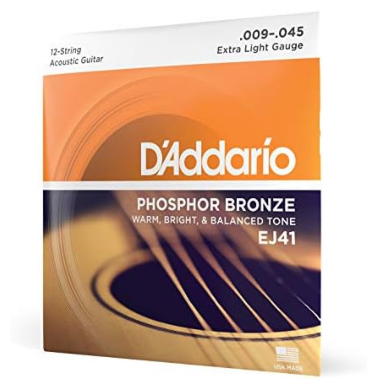

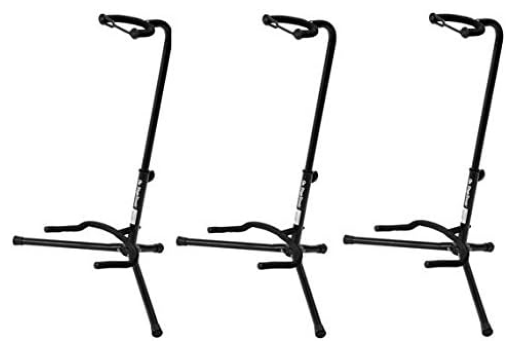

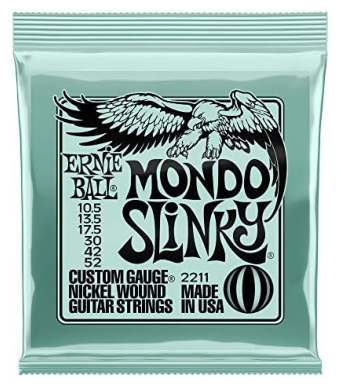

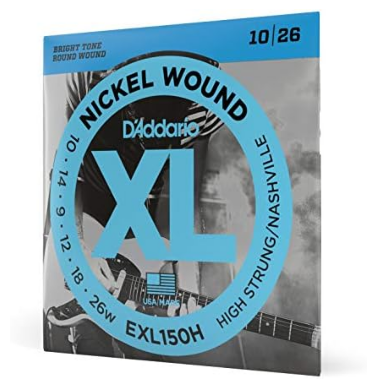

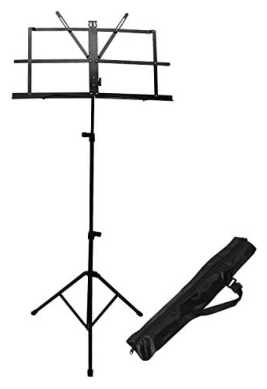

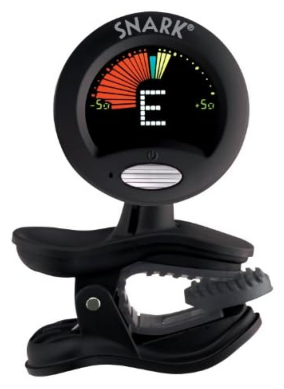

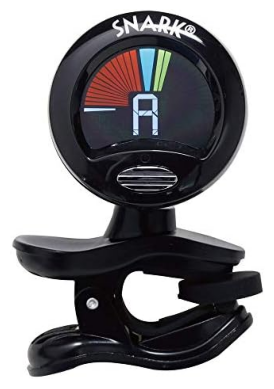

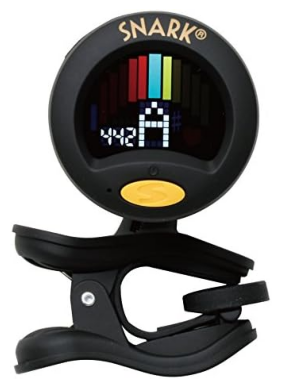

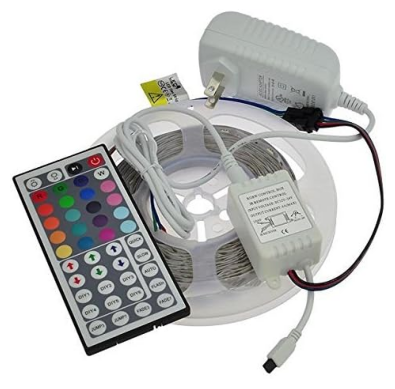

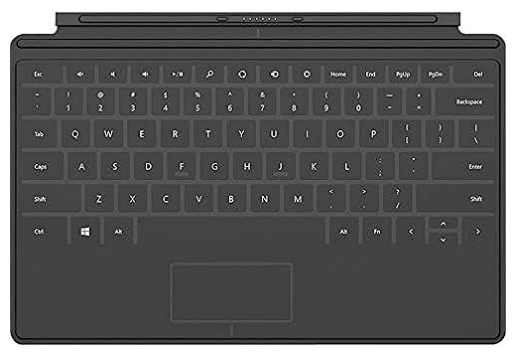

In [44]:
show_images(x)

# Bert4Rec: Transformer Based Recommendation

In [48]:
# Define the parameter dictionary

parameter_dict = {
    "data_path": "DSC210-group_proj/",
    "dataset": "Amazon",
    "train_neg_sample_args": None
}

In [ ]:
# Train utilizing recbole targeting the BERT4Rec model on our dataset defined in the paramert dictionar
run_recbole(model = "BERT4Rec", dataset= "Amazon", config_file_list = ["DSC210-group_proj/Amazon.yaml"], config_dict=parameter_dict)